In [2]:
import tensorflow as tf
from util import *
from util.parser import *
from util.img_kit import *
from IPython import display
import numpy as np
from scipy import ndimage
from scipy import misc
from os import walk
import os, json
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['figure.figsize'] = (10.0, 10) # set default size of plots

In [28]:
with open('data/test_metadata.json') as data_file:    
    metadata = json.load(data_file)

In [22]:
img_folder = "data/UCF-101-img-test/SoccerPenalty/"
imgs = [p[2] for p in walk(img_folder)][0]
imgs = list(filter(lambda x:x.startswith("v_SoccerPenalty_g01"), imgs))

In [68]:
data = np.concatenate([misc.imread(img_folder+i)[np.newaxis, ...] for i in imgs], axis = 0)
data = data.astype('float32')
print(data.shape)

(768, 240, 320, 3)


In [61]:
def generate_index(clip_indices):
    x_start_index = []
    x_end_index = []
    y_index = []
    for i in clip_indices:
        clip_list = metadata['SoccerPenalty'][0][i]
        start_index = list(range(0, len(clip_list) - gap))
        end_index = [i + gap for i in start_index]
        mid_index = [i + mid_gap for i in start_index]
        x_start_index += [metadata['SoccerPenalty'][0][i][j] for j in start_index]
        x_end_index += [metadata['SoccerPenalty'][0][i][j] for j in end_index]
        y_index += [metadata['SoccerPenalty'][0][i][j] for j in mid_index]
    return (x_start_index, x_end_index, y_index)

In [64]:
gap = 10
mid_gap = gap//2
# training set
train_x_start_index, train_x_end_index, train_y_index = generate_index(list(range(len(metadata['SoccerPenalty'][0])-1)))
# test set
test_x_start_index, test_x_end_index, test_y_index = generate_index([len(metadata['SoccerPenalty'][0])-1])

In [72]:
start_frames = data[train_x_start_index, :, :]
end_frames = data[train_x_end_index, :, :]
train_mean_frames = (start_frames + end_frames)/2
X_train = np.concatenate([start_frames - train_mean_frames, end_frames - train_mean_frames], axis = 3)
y_train = data[train_y_index, :, :]
start_frames = data[test_x_start_index, :, :]
end_frames = data[test_x_end_index, :, :]
test_mean_frames = (start_frames + end_frames)/2
X_test = np.concatenate([start_frames - test_mean_frames, end_frames - test_mean_frames], axis = 3)
y_test = data[test_y_index, :, :]
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(626, 240, 320, 6)
(626, 240, 320, 3)
(82, 240, 320, 6)
(82, 240, 320, 3)


In [71]:
batch_size = 16

In [73]:
def sample(X_train, y_train):
    """
    Select a batch size of data-point from X and y
    """
    size = X_train.shape[0]
    indices = np.random.choice(list(range(size)), size = batch_size)
    batch = (X_train[indices, :, :, :], y_train[indices, :, :, :])
    return batch

In [75]:
def conv_pool_block(inputs, conv_filter, conv_kernel, pool_size, pool_stride):
    conv1 = tf.layers.conv2d(inputs, 
                             conv_filter, 
                             conv_kernel,
                             padding='same', 
                             activation=tf.nn.relu)
    pooled = tf.layers.max_pooling2d(conv1, pool_size, pool_stride)
    return pooled
def dconv_block(inputs, dconv_filter, dconv_kernel, dconv_strides, activation = None, res_conv = None):
    if activation == 'ReLu':
        dconv = tf.layers.conv2d_transpose(inputs, 
                                       filters = dconv_filter, 
                                       kernel_size = dconv_kernel, 
                                       strides = dconv_strides, 
                                       padding='same',
                                       activation=tf.nn.relu)
    else:
        dconv = tf.layers.conv2d_transpose(inputs, 
                                       filters = dconv_filter, 
                                       kernel_size = dconv_kernel, 
                                       strides = dconv_strides, 
                                       padding='same')
    if res_conv is None:
        return dconv
    conv_concat = tf.concat([dconv, res_conv],3)
    return conv_concat

In [79]:
tf.reset_default_graph()
def my_model(X,y):
    block1 = conv_pool_block(X, 24, (3,3), (2,2), (2,2))  #(N, 128, 128, 24)
    block2 = conv_pool_block(block1, 48, (3,3), (2,2), (2,2))  #(N, 64, 64, 48)
    block3 = conv_pool_block(block2, 96, (3,3), (2,2), (2,2))  #(N, 32, 32, 96)
    block4 = conv_pool_block(block3, 192, (3,3), (2,2), (2,2))  #(N, 16, 16, 192)
    dconv_block1 = dconv_block(block4, 96, (3,3), (2,2), 'ReLu', block3) #(N, 32, 32, 192)
    dconv_block2 = dconv_block(dconv_block1, 48, (3,3), (2,2), 'ReLu',block2) #(N, 64, 64, 96)
    dconv_block3 = dconv_block(dconv_block2, 24, (3,3), (2,2), 'ReLu',block1) #(N, 128, 128, 48)
    y_out = dconv_block(dconv_block3, 3, (3,3),(2,2))
    return y_out

X = tf.placeholder(tf.float32, [None, 240, 320, 6])
y = tf.placeholder(tf.float32, [None, 240, 320, 3])

learning_rate = 3e-3
y_out = my_model(X,y)

mean_loss = tf.reduce_mean(tf.nn.l2_loss(y_out - y))
optimizer = tf.train.AdamOptimizer(learning_rate)
# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

pass

batch : 0  loss: 2.975e+10
batch : 10  loss: 2.835e+10
batch : 20  loss: 2.639e+10
batch : 30  loss: 1.712e+10
batch : 40  loss: 1.337e+10
batch : 50  loss: 1.044e+10
batch : 60  loss: 7.164e+09


KeyboardInterrupt: 

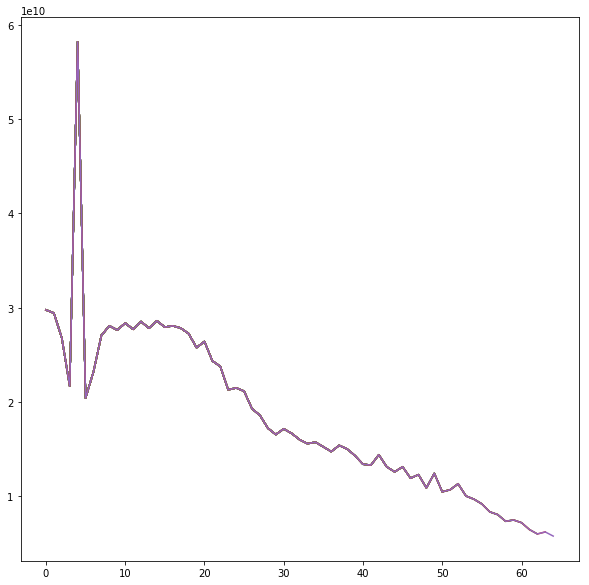

In [80]:
iterations = 200
sess =  tf.Session()
sess.run(tf.global_variables_initializer())
variables = [mean_loss,train_step]
history = []
for e in range(iterations):
    sampled = sample(X_train, y_train)
    feed_dict = {X: sampled[0], y: sampled[1]}
    loss, _ = sess.run(variables,feed_dict=feed_dict)
    history.append(loss)
    if e % 10 == 0:
        print('batch : {0}  loss: {1:.3e}'.format(e, loss))
    plt.plot(history)